# StockProjectDB Database Connection

This notebook connects to the MySQL database and displays data as DataFrames.

In [38]:
# Import required libraries
import pandas as pd
import pymysql
from sqlalchemy import create_engine
from config import DB_HOST, DB_PORT, DB_USER, DB_PASSWORD, DB_NAME

In [39]:
# Create database connection string
connection_string = f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

# Create SQLAlchemy engine
engine = create_engine(connection_string)

print(f"Connected to database: {DB_NAME}")

Connected to database: StockProjectDB


In [40]:
# Optional: Show all tables in the database (commented out - not needed for main workflow)
# query_tables = "SHOW TABLES"
# df_tables = pd.read_sql(query_tables, engine)
# print("Tables in StockProjectDB:")
# print(df_tables)

In [41]:
# Optional: Get table names (commented out - not needed for main workflow)
# table_names = df_tables.iloc[:, 0].tolist()
# print(f"\nFound {len(table_names)} table(s): {table_names}")

In [42]:
# Filter by Rec_Key = 'strong_buy' and last_update = second most recent date (earlier than latest)
# Query from stocks_2000 table (or Stocks if that's where the data is)

# First, get the second most recent date
query_second_latest = """
SELECT DISTINCT last_update 
FROM stocks_2000 
WHERE last_update < (SELECT MAX(last_update) FROM stocks_2000)
ORDER BY last_update DESC 
LIMIT 1
"""
second_latest_df = pd.read_sql(query_second_latest, engine)

if len(second_latest_df) > 0:
    earlier_date = second_latest_df['last_update'].iloc[0]
    
    # Filter by Rec_Key = 'strong_buy' and the earlier date
    query_filtered = f"""
    SELECT symbol 
    FROM stocks_2000 
    WHERE Rec_Key = 'strong_buy' 
      AND last_update = '{earlier_date}'
    """
    df = pd.read_sql(query_filtered, engine)
    
    print(f"Filtering by earlier date: {earlier_date}")
    print(f"Found {len(df)} rows with Rec_Key = 'strong_buy' for this date")
    print("\nSymbols with strong_buy recommendation (earlier update):")
    display(df)
else:
    print("No earlier date found. Using latest date instead.")
    query_filtered = """
    SELECT symbol 
    FROM stocks_2000 
    WHERE Rec_Key = 'strong_buy' 
      AND last_update = (SELECT MAX(last_update) FROM stocks_2000)
    """
    df = pd.read_sql(query_filtered, engine)
    print(f"Found {len(df)} rows with Rec_Key = 'strong_buy'")
    display(df)

No earlier date found. Using latest date instead.
Found 4 rows with Rec_Key = 'strong_buy'


,symbol
0,NVDA
1,GOOGL
2,MSFT
3,AMZN


In [30]:
# Install required packages for technical analysis (run this cell once)
import sys
import subprocess

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Install required packages
try:
    import mplfinance
except ImportError:
    print("Installing mplfinance...")
    install_package("mplfinance")
    
try:
    import yfinance
except ImportError:
    print("Installing yfinance...")
    install_package("yfinance")

print("All required packages are installed!")

All required packages are installed!


In [31]:
# Import libraries for technical analysis visualization
import warnings
warnings.filterwarnings('ignore')  # Suppress FutureWarnings from yfinance

import yfinance as yf
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
import numpy as np

print("Visualization libraries imported successfully!")

Visualization libraries imported successfully!


Generating technical analysis for 4 stocks: ['NVDA', 'GOOGL', 'MSFT', 'AMZN']

Processing NVDA...


  ✗ Error processing NVDA: unsupported format string passed to Series.__format__

Processing GOOGL...
  ✗ Error processing GOOGL: unsupported format string passed to Series.__format__

Processing MSFT...
  ✗ Error processing MSFT: unsupported format string passed to Series.__format__

Processing AMZN...
  ✗ Error processing AMZN: unsupported format string passed to Series.__format__

Completed analysis for 4 stocks.


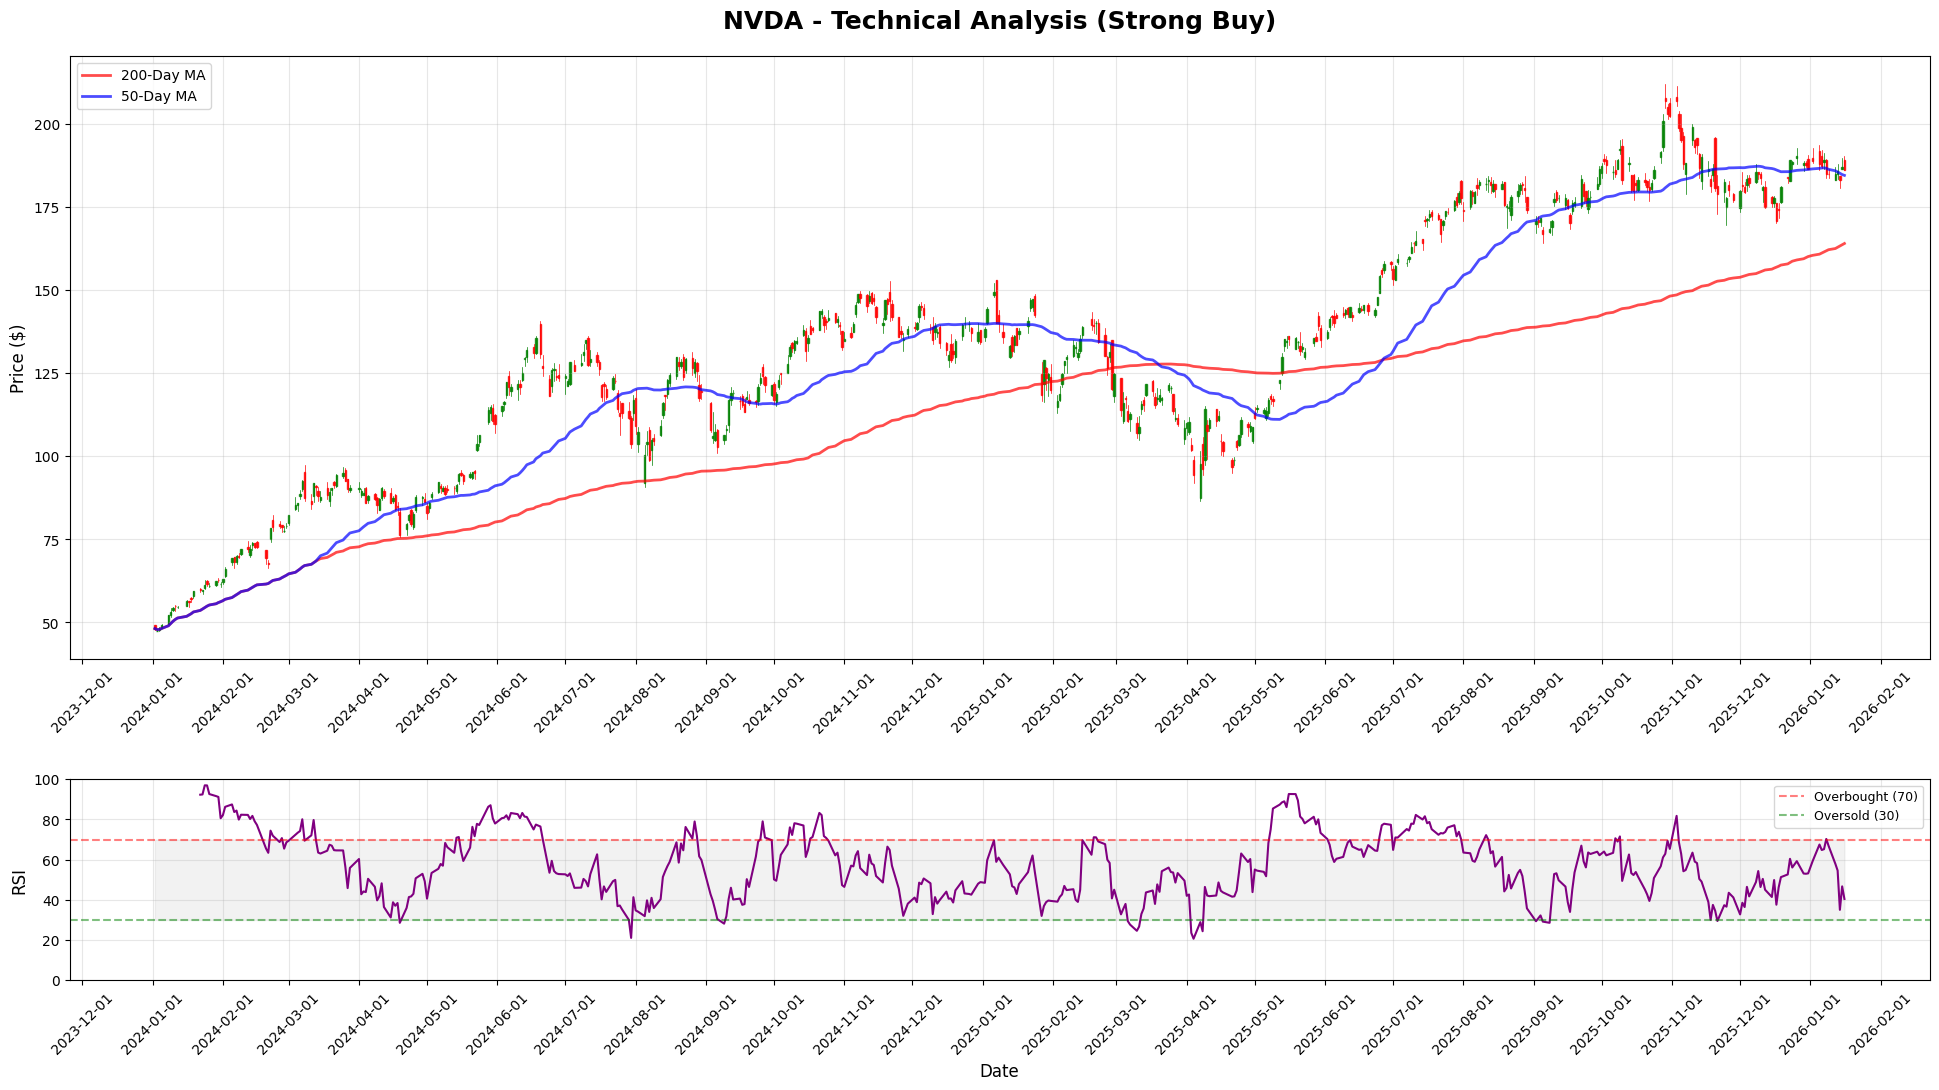

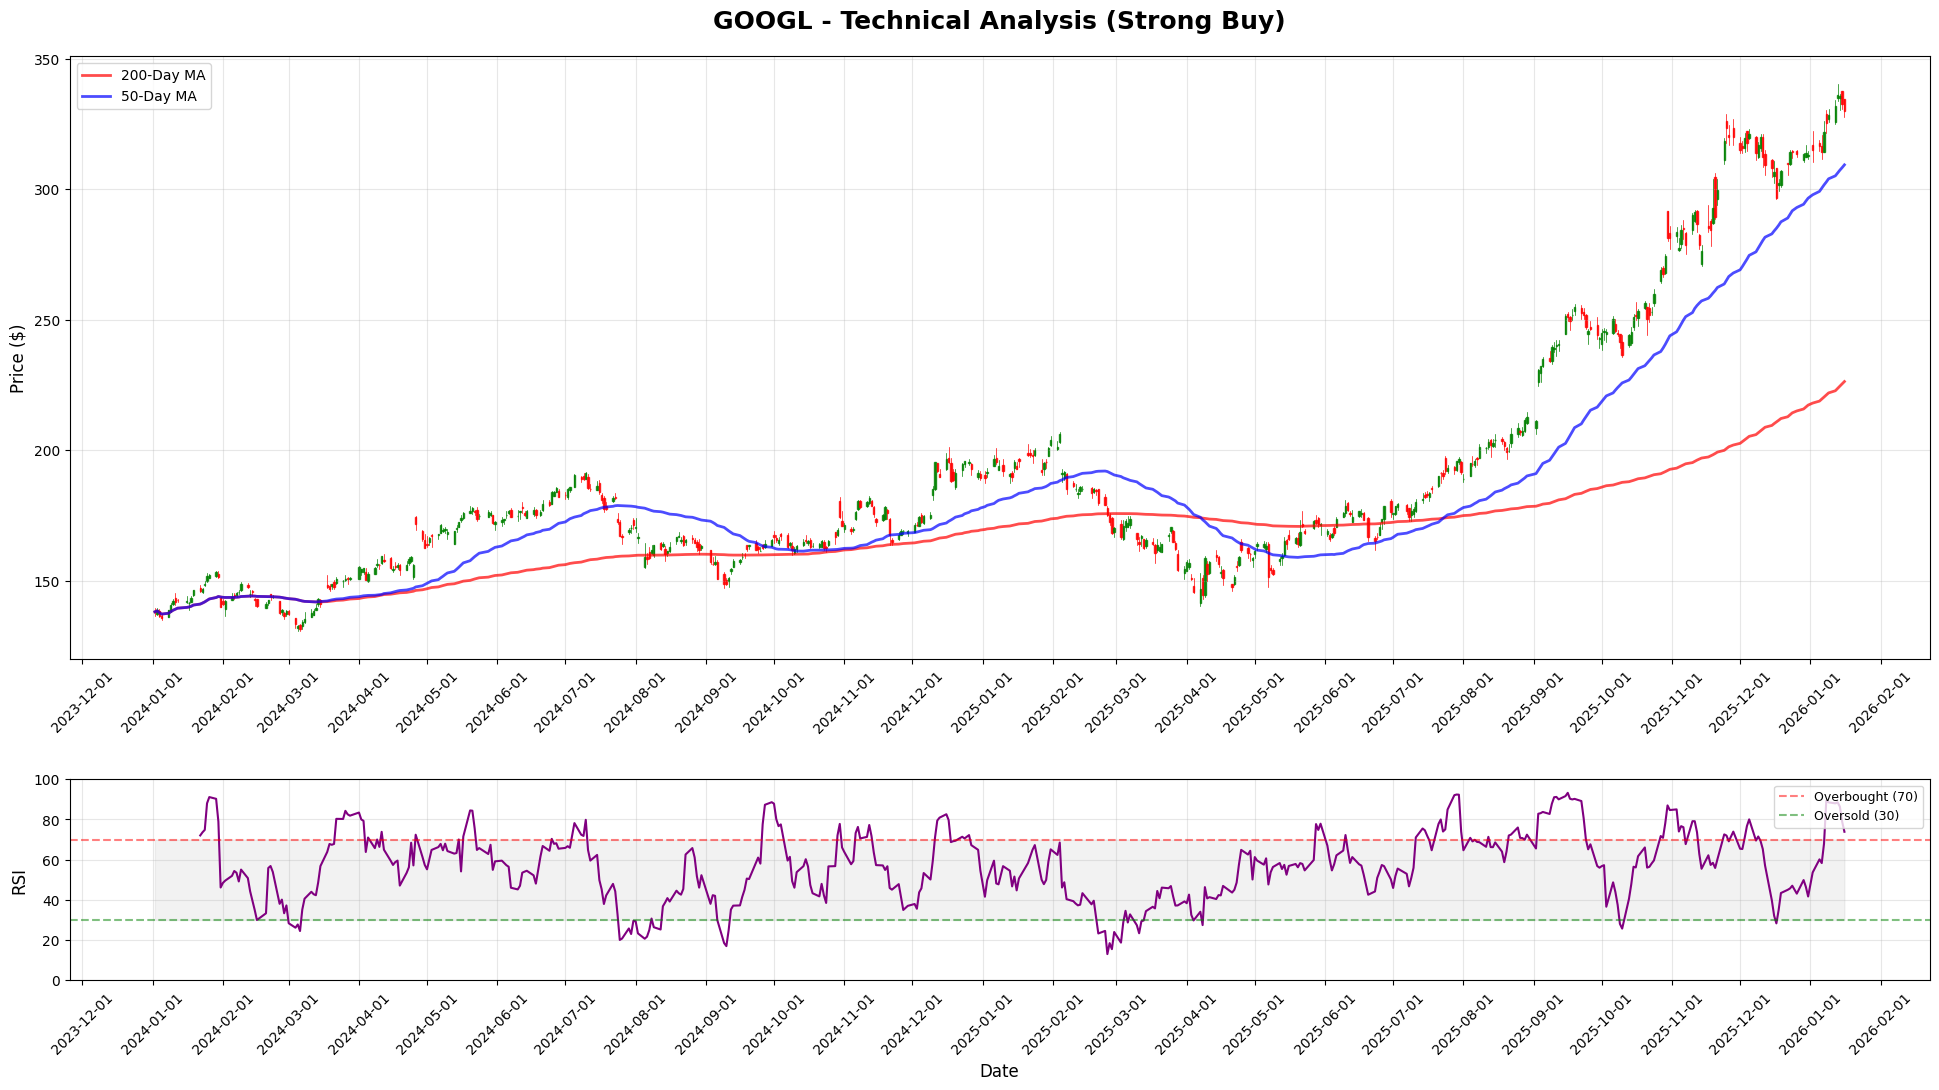

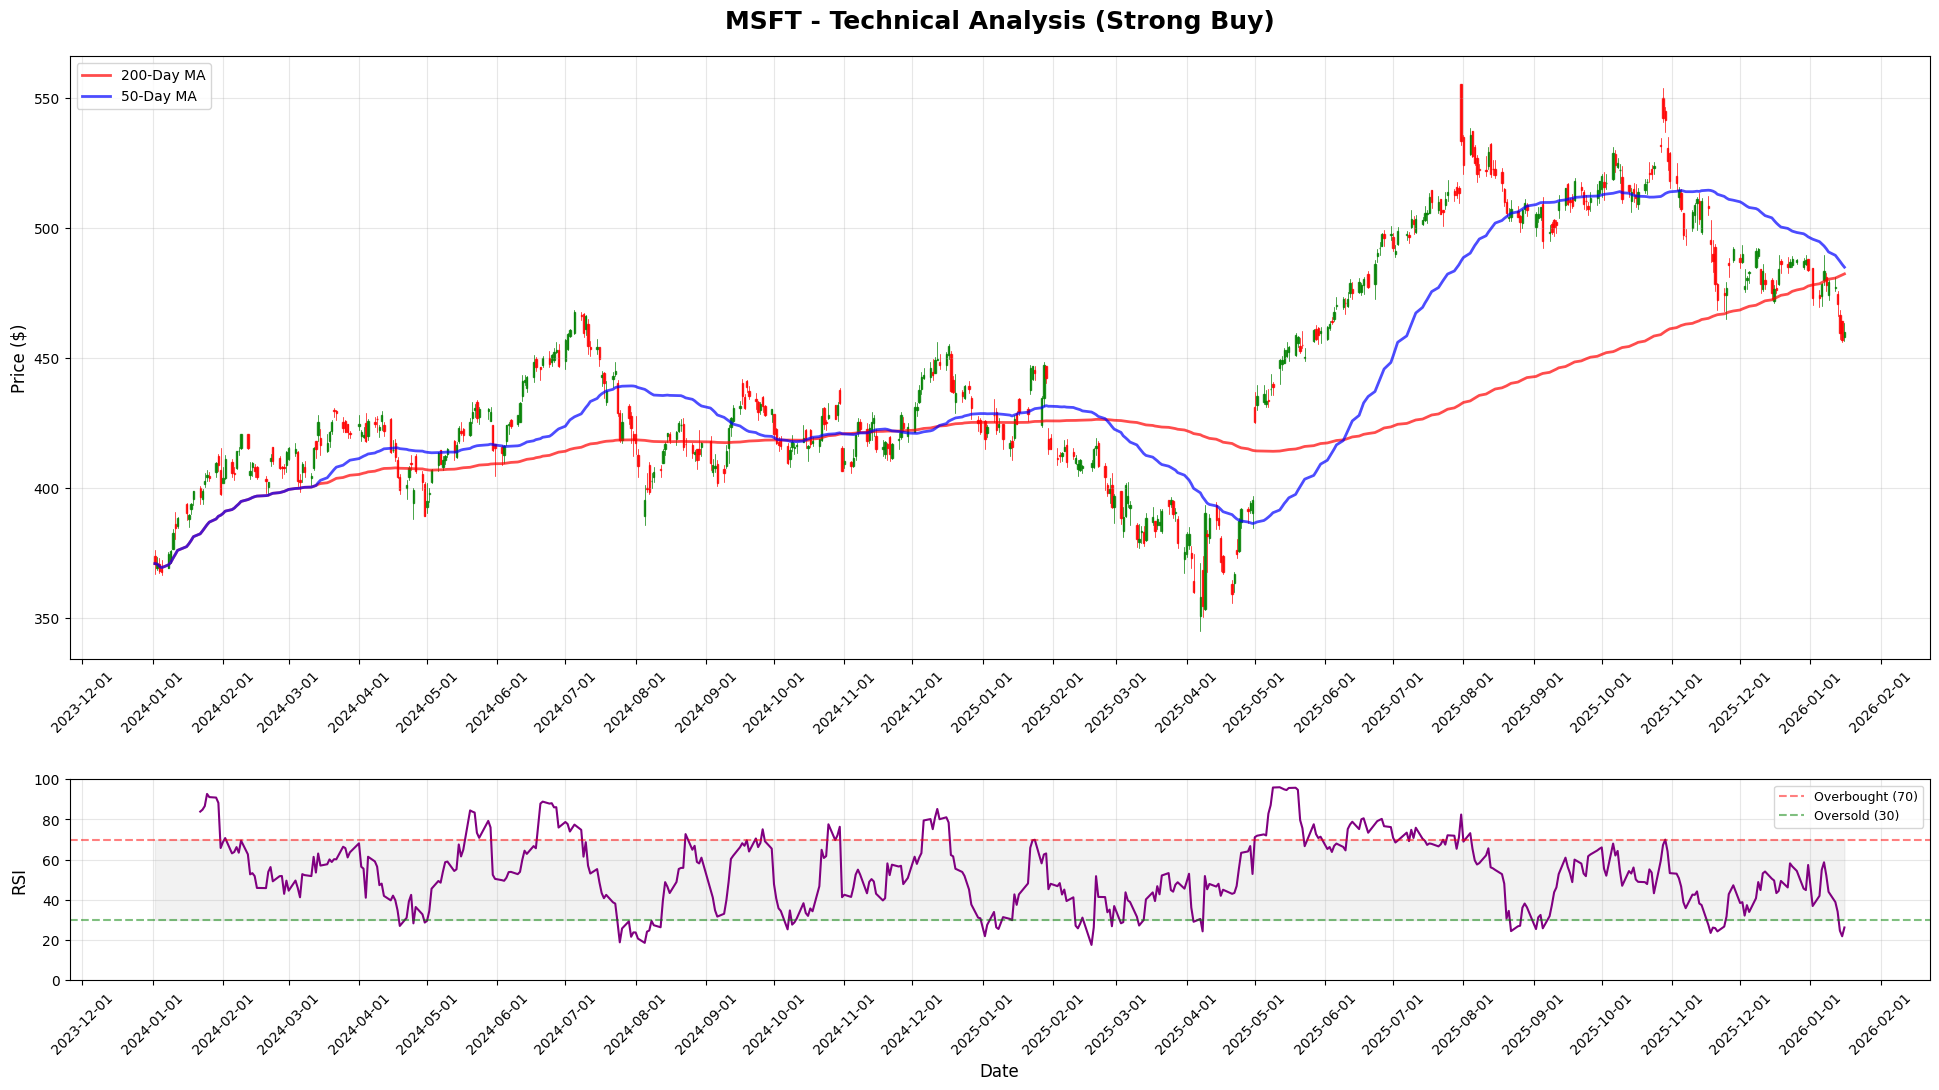

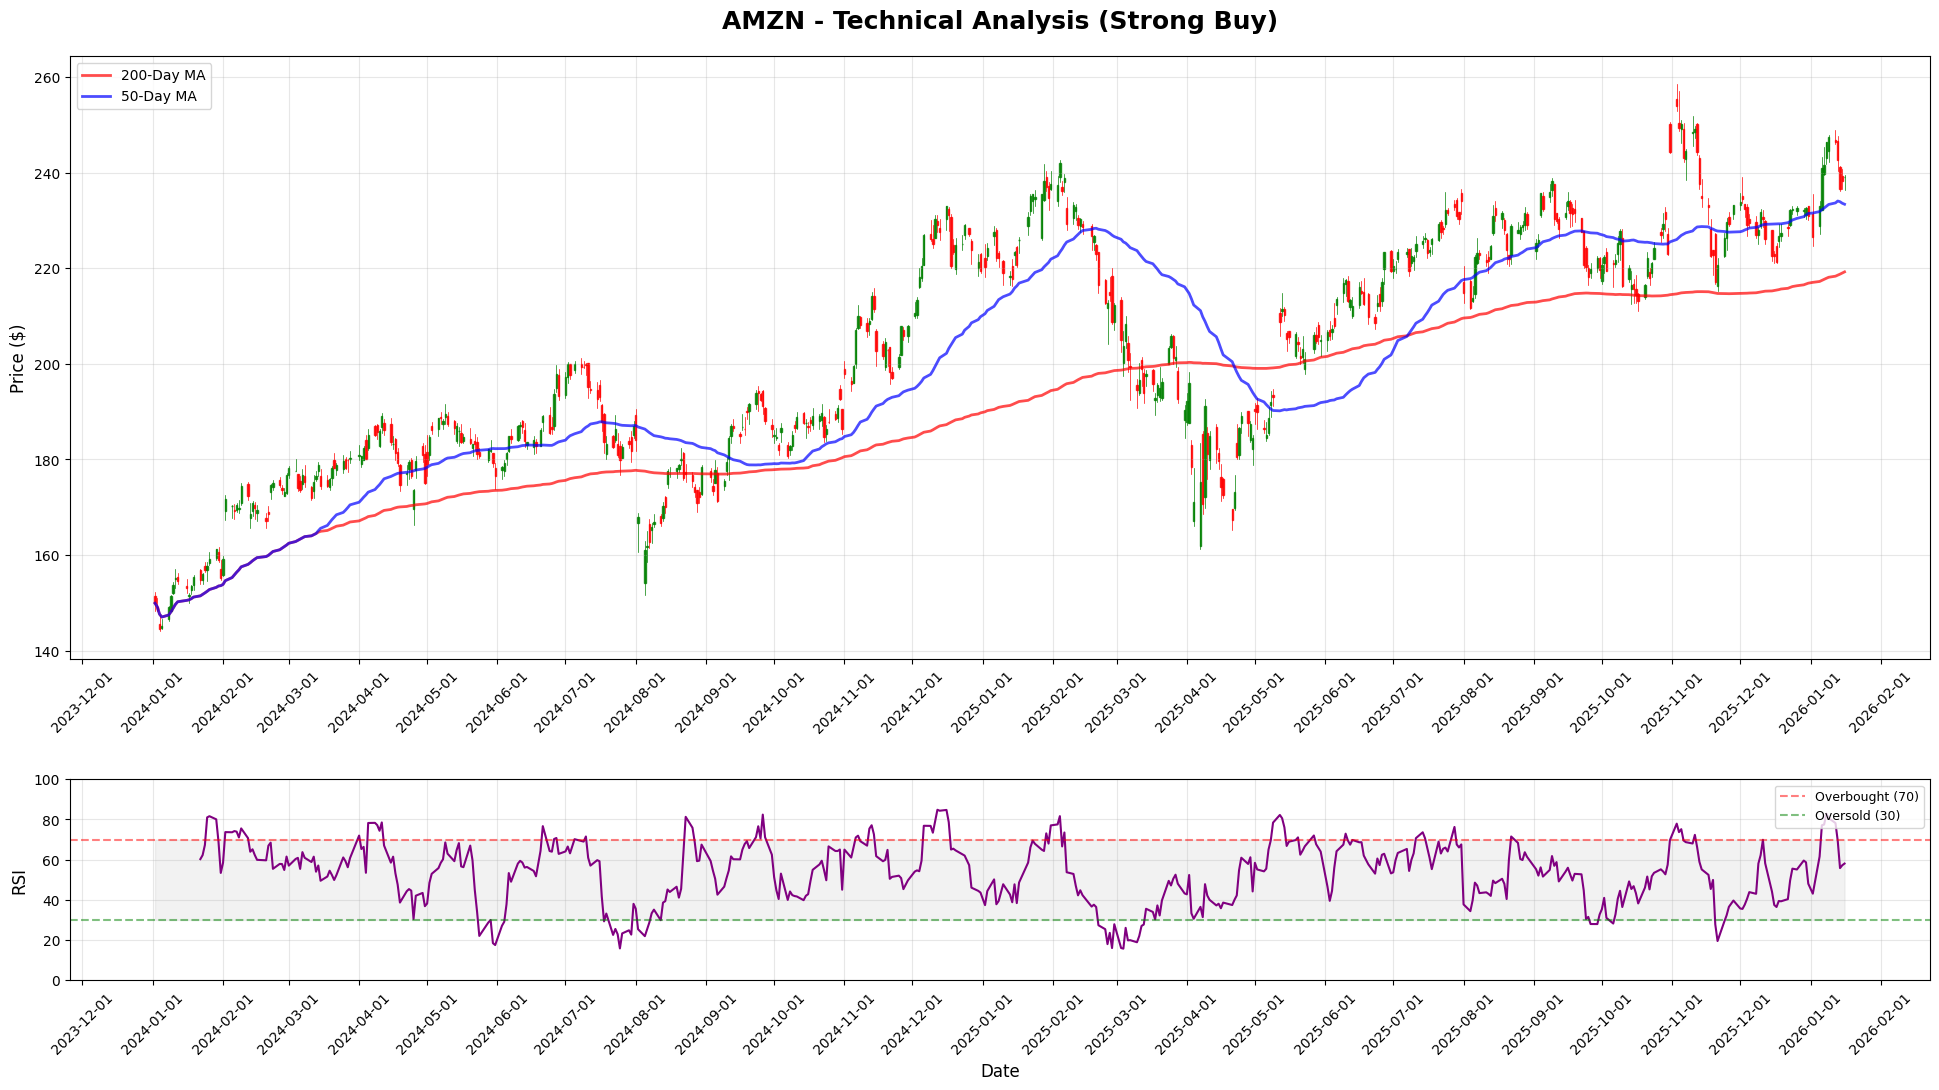

In [32]:
# Get list of symbols from filtered dataframe and generate technical analysis
# Make sure df is defined from the previous cell
if 'df' in locals() and len(df) > 0:
    list_of_stocks = df['symbol'].tolist()
    print(f"Generating technical analysis for {len(list_of_stocks)} stocks: {list_of_stocks}\n")
    
    # Generate technical analysis visualization for each stock
    for ticker in list_of_stocks:
        try:
            print(f"Processing {ticker}...")
            
            # Fetch stock data from Yahoo Finance
            stock_data = yf.download(ticker, start='2024-01-01', progress=False, auto_adjust=False)
            
            if stock_data.empty:
                print(f"  ⚠ No data available for {ticker}\n")
                continue
            

            
            # Calculate moving averages
            stock_data['200_MA'] = stock_data['Close'].rolling(window=200, min_periods=1).mean()
            stock_data['50_MA'] = stock_data['Close'].rolling(window=50, min_periods=1).mean()
            
            # Calculate RSI (Relative Strength Index)
            delta = stock_data['Close'].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
            rs = gain / loss
            stock_data['RSI'] = 100 - (100 / (1 + rs))
            
            # Convert index to matplotlib date format
            stock_data_reset = stock_data.reset_index()
            stock_data_reset['Date'] = stock_data_reset['Date'].apply(mdates.date2num)
            
            # Create figure with subplots: price chart and RSI
            fig = plt.figure(figsize=(24, 12))
            gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.3)
            
            # Main price chart with candlesticks and moving averages
            ax1 = fig.add_subplot(gs[0])
            
            # Plot candlestick chart
            candlestick_ohlc(ax1, stock_data_reset[['Date', 'Open', 'High', 'Low', 'Close']].values, 
                           width=0.6, colorup='g', colordown='r', alpha=0.8)
            
            # Plot moving averages
            ax1.plot(stock_data_reset['Date'], stock_data_reset['200_MA'], color='red', 
                    label='200-Day MA', linewidth=2, alpha=0.7)
            ax1.plot(stock_data_reset['Date'], stock_data_reset['50_MA'], color='blue', 
                    label='50-Day MA', linewidth=2, alpha=0.7)
            
            ax1.set_title(f'{ticker} - Technical Analysis (Strong Buy)', fontsize=18, fontweight='bold', pad=20)
            ax1.set_ylabel('Price ($)', fontsize=12)
            ax1.grid(True, alpha=0.3)
            ax1.legend(loc='upper left', fontsize=10)
            
            # Format x-axis (show diagonal dates on price chart)
            ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            ax1.xaxis.set_major_locator(mdates.MonthLocator())
            plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
            
            # RSI subplot
            ax3 = fig.add_subplot(gs[1], sharex=ax1)
            ax3.plot(stock_data_reset['Date'], stock_data_reset['RSI'], color='purple', linewidth=1.5)
            ax3.axhline(y=70, color='r', linestyle='--', alpha=0.5, label='Overbought (70)')
            ax3.axhline(y=30, color='g', linestyle='--', alpha=0.5, label='Oversold (30)')
            ax3.fill_between(stock_data_reset['Date'], 30, 70, alpha=0.1, color='gray')
            ax3.set_ylabel('RSI', fontsize=12)
            ax3.set_ylim(0, 100)
            ax3.set_xlabel('Date', fontsize=12)
            ax3.grid(True, alpha=0.3)
            ax3.legend(loc='upper right', fontsize=9)
            
            # Format bottom x-axis
            ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            ax3.xaxis.set_major_locator(mdates.MonthLocator())
            plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
            
            # Get current price info
            current_price = stock_data['Close'].iloc[-1]
            price_change = stock_data['Close'].iloc[-1] - stock_data['Close'].iloc[-2]
            price_change_pct = (price_change / stock_data['Close'].iloc[-2]) * 100
            
            # Add text box with current stats
            stats_text = f'Current: ${current_price:.2f} ({price_change_pct:+.2f}%)\n'
            stats_text += f'50 MA: ${stock_data["50_MA"].iloc[-1]:.2f}\n'
            stats_text += f'200 MA: ${stock_data["200_MA"].iloc[-1]:.2f}\n'
            stats_text += f'RSI: {stock_data["RSI"].iloc[-1]:.1f}'
            ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, 
                    fontsize=10, verticalalignment='top', 
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            
            plt.tight_layout()
            plt.show()
            print(f"  ✓ Chart generated for {ticker}\n")
            
        except Exception as e:
            print(f"  ✗ Error processing {ticker}: {str(e)}\n")
            continue
    
    print(f"Completed analysis for {len(list_of_stocks)} stocks.")
else:
    print("No filtered symbols found. Please run the previous cell first to get filtered strong_buy symbols.")